In [ ]:
!pip install transformers transformers_stream_generator tiktoken transformer_lens einops jaxtyping colorama

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
 

In [ ]:
import torch
import functools
import einops
import requests
import pandas as pd
import io
import textwrap
import gc
import contextlib
import functools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import Tensor
from typing import List, Callable, Tuple
from transformers import AutoModelForCausalLM,AutoTokenizer

# ProtGPT2

In [ ]:
#de la página oficial en HF
from transformers import pipeline
protgpt2 = pipeline('text-generation', model="nferruz/ProtGPT2")
sequences = protgpt2("<|endoftext|>", max_length=100, do_sample=True, top_k=950, repetition_penalty=1.2, num_return_sequences=10, eos_token_id=0)
sequences

KeyboardInterrupt: 

Ahora instancio el modelo

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
protgpt2_model = AutoModelForCausalLM.from_pretrained("nferruz/ProtGPT2", torch_dtype="auto", device_map="auto") #738 M params
protgpt2_tokenizer = AutoTokenizer.from_pretrained("nferruz/ProtGPT2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
processed = protgpt2_tokenizer.tokenize('<|endoftext|>MSTVSRY')
print(f'tokenized = {processed}')
encoded = protgpt2_tokenizer.encode('<|endoftext|>MSTVSRY')
print(f'decoded = {encoded}')
protgpt2_tokenizer('<|endoftext|>MSTVSRY', return_tensors="pt")

tokenized = ['<|endoftext|>', 'MS', 'TVS', 'RY']
decoded = [0, 382, 1002, 416]


{'input_ids': tensor([[   0,  382, 1002,  416]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

# Cargo la data

In [ ]:
def load_sequence_tsv(datapath:str):
  df = pd.read_csv(datapath, sep='\t')
  #length_filtered = df[df['Length']<300]
  #species_filtered = length_filtered[length_filtered['Organism'].isin(['Homo sapiens (Human)','Mus musculus (Mouse)','Arabidopsis thaliana (Mouse-ear cress)','Rattus norvegicus (Rat)'])]

  # normalizar este gráfico!
  # hacer un boxplot también
  sns.histplot(data=length_filtered[['Length']], x=f"Length")
  plt.show()
  return df[df['Length']<300] #subsampleo a las proteínas que tienen menos de 300 aminoácidos

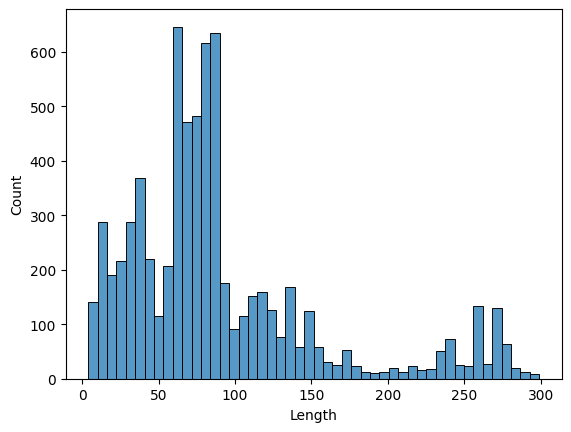

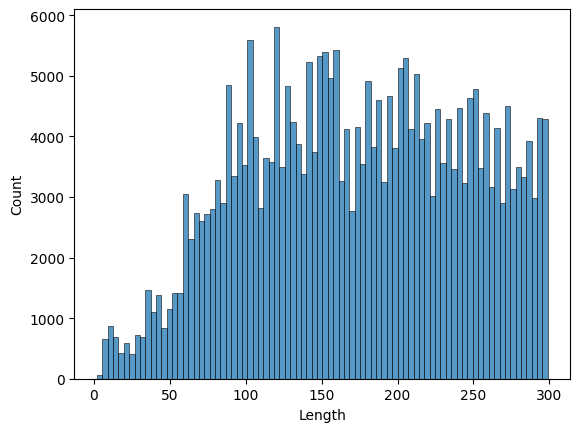

In [ ]:
tox_sequences_df = load_sequence_tsv('toxins_sprot_clean.tsv')
non_tox_sequences_df = load_sequence_tsv('non_toxins_sprot_clean.tsv')

subsample_size = 5000

tox_sequences_df = tox_sequences_df.sample(n=subsample_size, random_state=42)
non_tox_sequences_df = non_tox_sequences_df.sample(n=subsample_size, random_state=42)

tox_seqs = tox_sequences_df['Sequence'].tolist()
non_tox_seqs = non_tox_sequences_df['Sequence'].tolist()

## Hooking fn


1. Agarro las act por cada dataset (tox_activations & non_tox_activations)
2. Las proyecto en UMAP a ver si se separan

In [ ]:
@contextlib.contextmanager
def add_hooks(
    module_forward_pre_hooks: List[Tuple[torch.nn.Module, Callable]],
    module_forward_hooks: List[Tuple[torch.nn.Module, Callable]],
    **kwargs
):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_forward_pre_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward pre hook on the module
    module_forward_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for module, hook in module_forward_pre_hooks:
            partial_hook = functools.partial(hook, **kwargs)
            handles.append(module.register_forward_pre_hook(partial_hook))
        for module, hook in module_forward_hooks:
            partial_hook = functools.partial(hook, **kwargs)
            handles.append(module.register_forward_hook(partial_hook))
        yield
    finally:
        for h in handles:
            h.remove()


def get_activations(model, tokenizer, instructions, block_modules: List[torch.nn.Module], store_means=True, batch_size=8, positions=[-1]):

    def mean_hook(layer, cache, n_samples, positions):
        def _hook(module, inputs):
            act = inputs[0][:, positions, :]          # [B, P, d]
            cache[:, layer] += act.sum(0) / n_samples # mean update
        return _hook


    def sample_hook(layer, cache, positions, batch_start):
        def _hook(module, inputs):
            act = inputs[0][:, positions, :]              # [B, P, d]
            B = act.size(0)
            cache[batch_start:batch_start+B, :, layer, :] = act
        return _hook

    torch.cuda.empty_cache()

    n_positions = len(positions)
    n_layers = model.config.num_hidden_layers
    n_samples = len(instructions)
    d_model = model.config.hidden_size
    device= model.device

    if store_means:
        # we store the mean activations in high-precision to avoid numerical issues
        activations = torch.zeros((n_positions, n_layers, d_model), dtype=torch.float64, device=device)
    else:
        # to avoid mem issues we fallback to .32 precision
        activations = torch.zeros((n_samples, n_positions, n_layers, d_model), dtype=torch.float32, device=device)

    for batch_start in tqdm(range(0, n_samples, batch_size), total = int(n_samples/batch_size)):
        inputs = tokenizer(
            instructions[batch_start:batch_start+batch_size],
            return_tensors="pt",
            padding=True
            )

        if store_means:
            fwd_pre_hooks = [
                (block_modules[l], mean_hook(l, activations, n_samples, positions))
                for l in range(n_layers)
            ]
        else:
            fwd_pre_hooks = [
                (block_modules[l], sample_hook(l, activations, positions, batch_start))
                for l in range(n_layers)
            ]
        with torch.inference_mode():
          with add_hooks(fwd_pre_hooks, []):
              model(
                  input_ids=inputs.input_ids.to(model.device),
                  attention_mask=inputs.attention_mask.to(model.device),
              )


    # of size (n_positions, n_layers, d_model) if store_means = False
    # of size (n_samples, n_positions, n_layers, d_model) if store_means = True
    return activations

def get_activations_for_datasets(model, tokenizer, tox_seqs, non_tox_seqs, block_modules: List[torch.nn.Module], batch_size=32, positions=[-1]):

    store_means = False

    activations_tox = get_activations(model, tokenizer, tox_seqs, block_modules, batch_size=batch_size, positions=positions, store_means=False)
    activations_non_tox = get_activations(model, tokenizer, non_tox_seqs, block_modules, batch_size=batch_size, positions=positions, store_means=False)

    return activations_tox, activations_non_tox


In [ ]:
block_modules = list(protgpt2_model.transformer.h)
protgpt2_tokenizer.add_special_tokens({'pad_token': '<|endoftext|>'})

activations_tox, activations_non_tox = get_activations_for_datasets(
    protgpt2_model,
    protgpt2_tokenizer,
    tox_seqs,
    non_tox_seqs,
    block_modules
) # of size (n_samples, pos, n_layers, d_model)



157it [03:13,  1.23s/it]
157it [03:50,  1.47s/it]


In [ ]:
torch.save(acts_combined, 'acts_combined_protgpt2_random5000_toxdl2.pt')

### Plotting

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

try:
    import umap  # pip install umap-learn
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False


def _prep_embeddings(cache: torch.Tensor,
                     layer: int,
                     positions: str | list[int] = "mean") -> np.ndarray:
    """
    Returns a 2-D array  [n_samples,  F]  suitable for TSNE/UMAP.

    positions
    ---------
    • "mean"  – average activations over the tracked positions.
    • list[int] – keep only these position indices (e.g. [-1]).
    • "flatten" – concatenate all positions (shape → P*d_model).
    """
    # → [samples, positions, d_model]
    layer_act = cache[:, :, layer, :].cpu().float()

    if positions == "mean":
        out = layer_act.mean(dim=1)
    elif positions == "flatten":
        out = layer_act.reshape(layer_act.shape[0], -1)
    else:                       # explicit list of indices
        out = layer_act[:, positions, :].reshape(layer_act.shape[0], -1)

    return out.numpy()          # sklearn likes numpy


def plot_layerwise_embedding(cache,
                             method="umap",
                             positions="mean",
                             labels=None,           # ← pass the numeric labels here
                             label_names=None,      # ← optional names for legend
                             pca_dim=50,
                             umap_kw=None,
                             tsne_kw=None,
                             figsize=(4, 4),
                             **scatter_kw):

    umap_kw  = umap_kw  or {}
    tsne_kw  = tsne_kw  or {"perplexity": 30, "init": "pca", "learning_rate": "auto"}
    scatter_kw = {"s": 6, "alpha": .7, **scatter_kw}

    n_layers  = cache.shape[2]
    n_cols    = int(np.ceil(np.sqrt(n_layers)))
    n_rows    = int(np.ceil(n_layers / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize[0]*n_cols, figsize[1]*n_rows),
                             squeeze=False)

    for ℓ in tqdm(range(n_layers), total = n_layers, desc= f'Plotting activations with {method}'):
        X = _prep_embeddings(cache, ℓ, positions)

        # speed-up
        if pca_dim and X.shape[1] > pca_dim:
            X = PCA(n_components=pca_dim).fit_transform(X)

        embed = (umap.UMAP(n_components=2, **umap_kw).fit_transform(X)
                 if method == "umap"
                 else TSNE(n_components=2, **tsne_kw).fit_transform(X))

        ax = axes[ℓ // n_cols, ℓ % n_cols]
        sc = ax.scatter(embed[:, 0], embed[:, 1],
                        **scatter_kw)
        ax.set_title(f"Layer {ℓ}")
        ax.set_xticks([]); ax.set_yticks([])

    # build a single legend (once) using proxy artists
    if labels is not None and label_names is not None:
        unique = np.unique(labels)
        handles = [plt.Line2D([0], [0], linestyle="",
                              marker="o", markersize=6,
                              markerfacecolor=scatter_kw.get("cmap", "tab10")(lab)
                              if hasattr(scatter_kw.get("cmap", None), "__call__")
                              else sc.get_cmap()(lab)
                              )
                   for lab in unique]
        names   = [label_names[int(lab)] for lab in unique]
        fig.legend(handles, names, loc="center right", title="Class")

    for j in range(n_layers, n_rows * n_cols):
        axes[j // n_cols, j % n_cols].axis("off")

    fig.suptitle(f"{method.upper()} projection (positions={positions})")
    fig.tight_layout(rect=[0, 0, 0.93, 0.95])
    return fig

Plotting activations with umap: 100%|██████████| 36/36 [08:50<00:00, 14.72s/it]


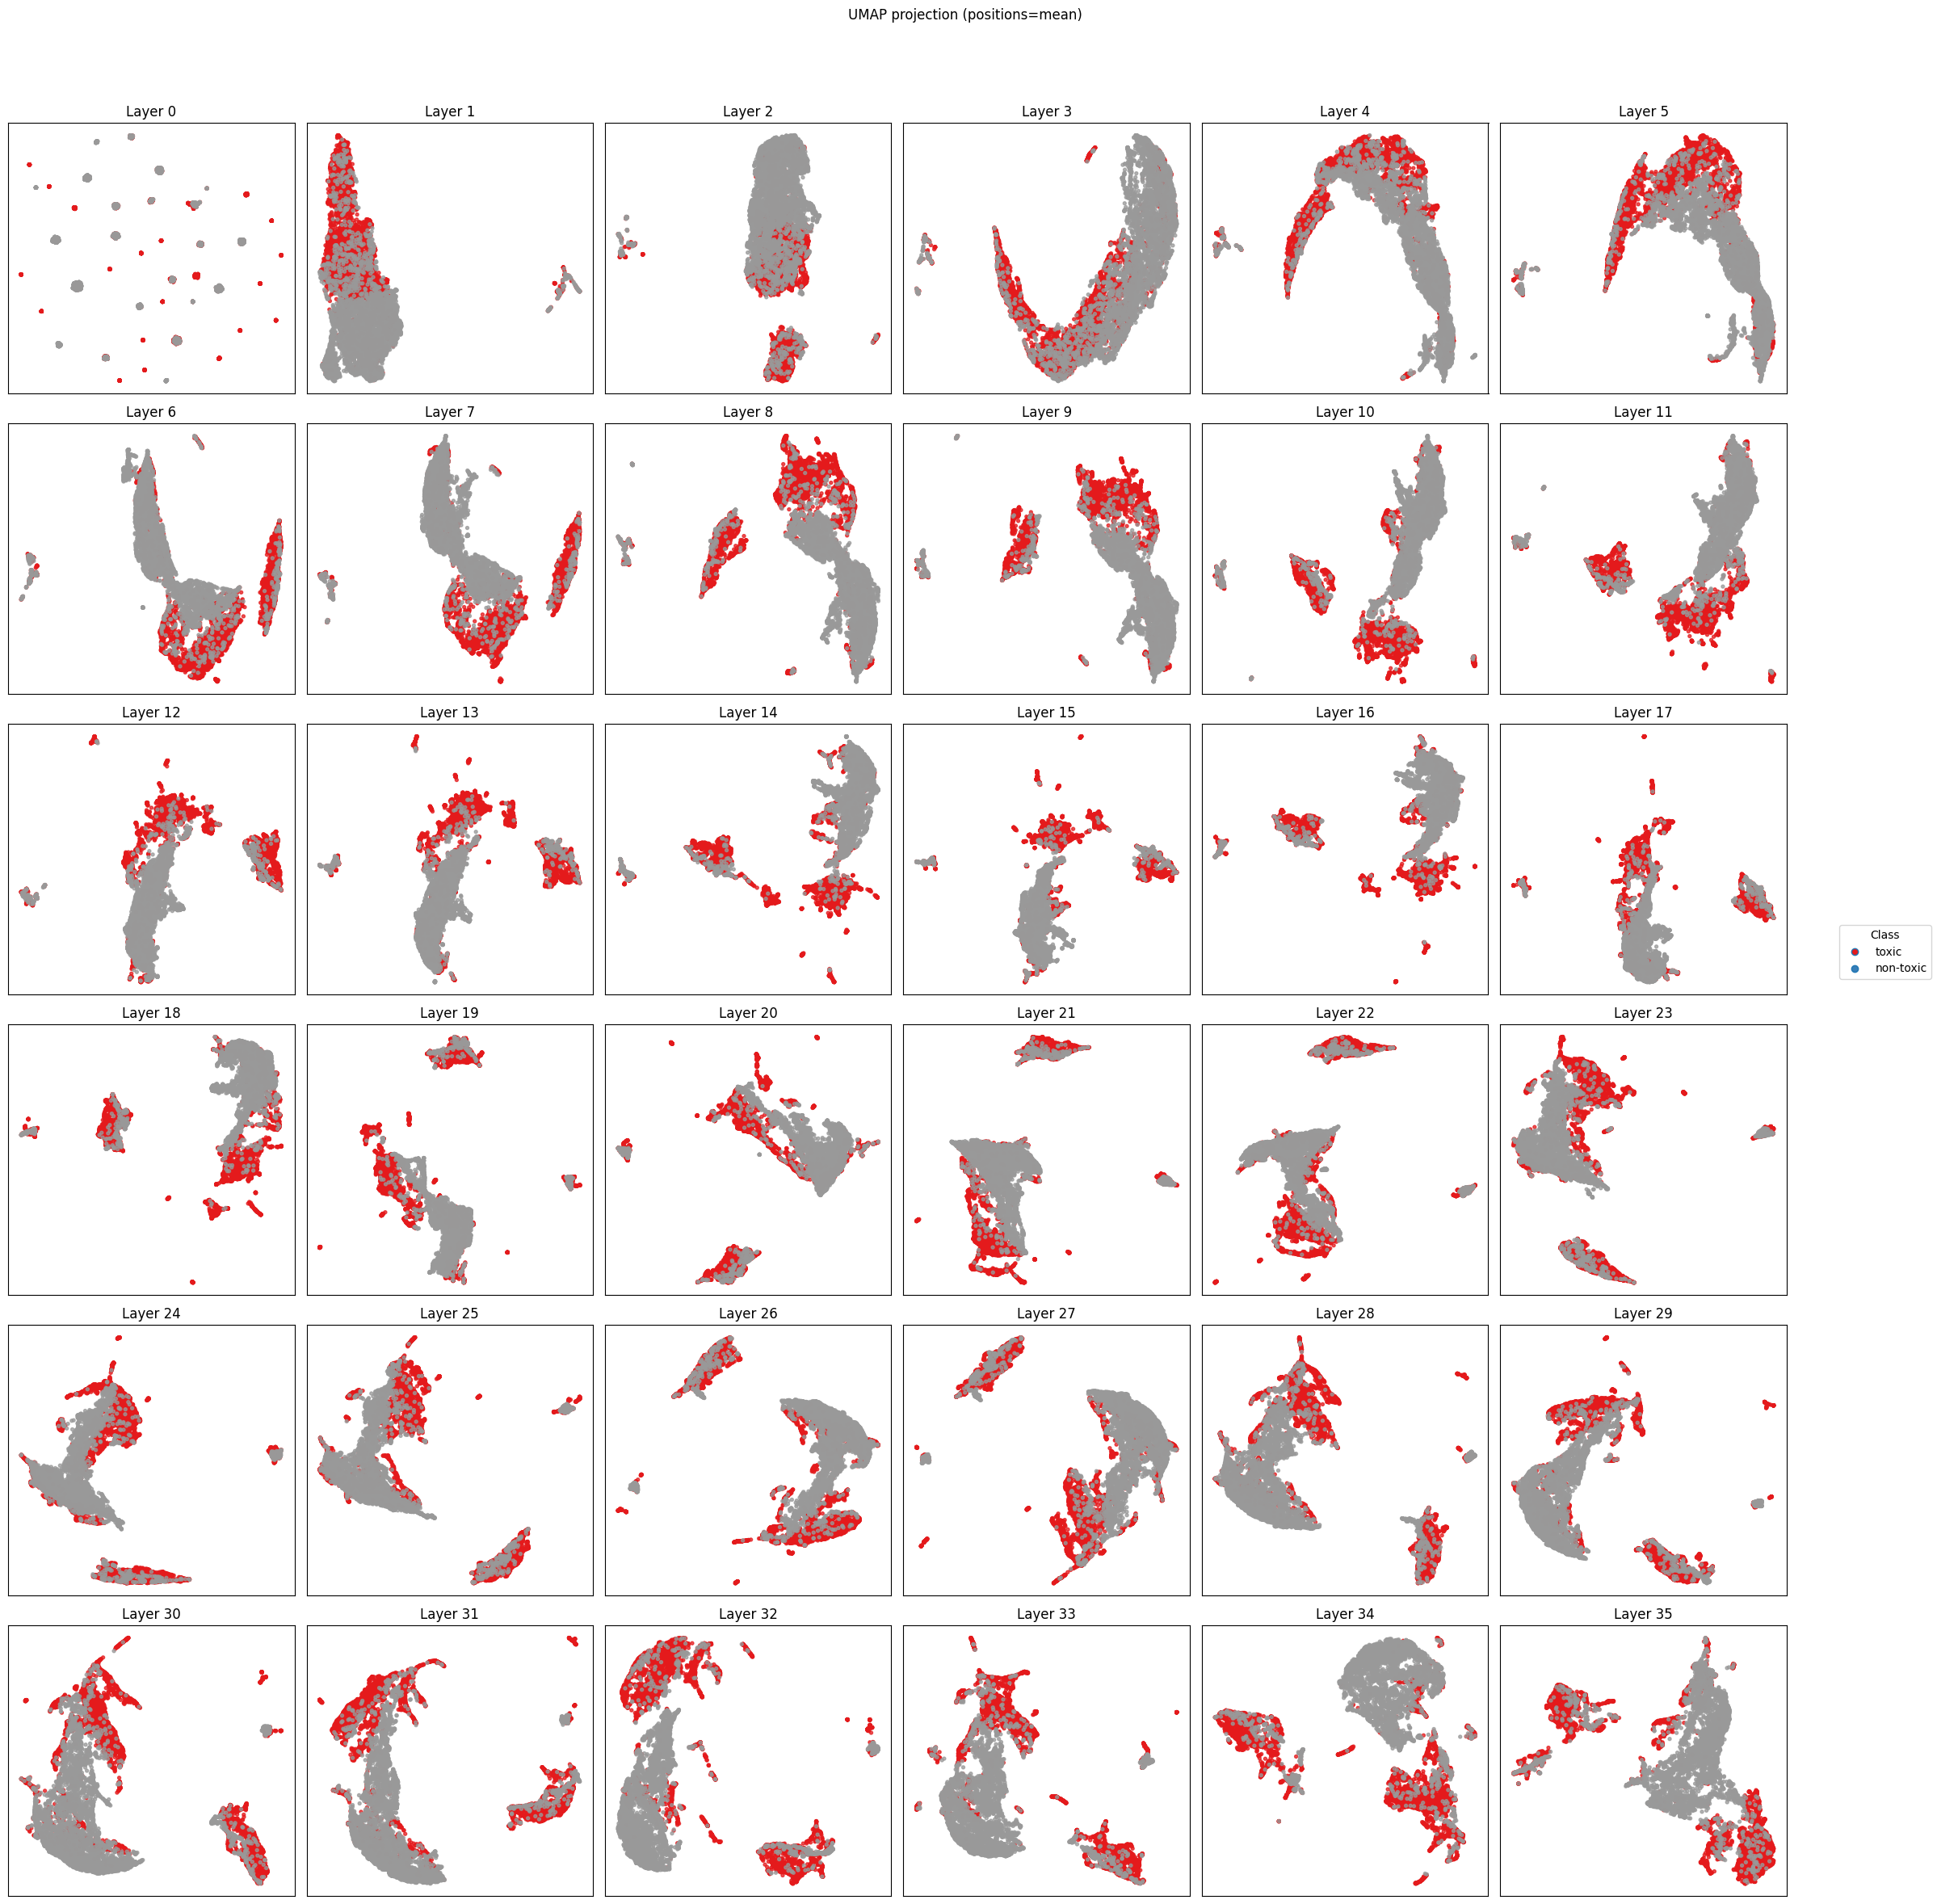

In [ ]:
# --- 1. gather activations ---------------------------------------------------
acts_tox = activations_tox
acts_non = activations_non_tox
# --- 2. concatenate and label -----------------------------------------------
acts_combined = torch.cat([acts_tox, acts_non], dim=0)   # [Nt+Nn, P, L, d]

labels = np.concatenate([
    np.zeros(acts_tox.shape[0], dtype=int),     # 0 = tox
    np.ones (acts_non.shape[0], dtype=int)      # 1 = non-tox
])

# --- 3. visualise ------------------------------------------------------------
scatter_opts = {"c": labels, "cmap": "Set1", "s": 8, "alpha": 0.75}

fig = plot_layerwise_embedding(
    cache       = acts_combined,
    method      = "umap",
    positions   = "mean",
    labels      = labels,
    label_names = {0: "toxic", 1: "non-toxic"},
    **scatter_opts               # <- unpack correctly named options
)
plt.show()

In [ ]:
labels_tensor = torch.tensor(labels)
torch.save(labels_tensor, 'labels_tensor_protgpt2_random5000_toxdl2.pt')

### Visualizing how different they are represented in each layer

In [ ]:
import numpy as np, torch
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

def layerwise_linear_probe(acts, labels, positions="mean"):
    N, P, L, d = acts.shape
    # collapse the positions dimension ------------------------------------
    if positions == "mean":
        embeds = acts.mean(1)                # (N, L, d)
    elif positions == "flatten":             # concat all positions
        embeds = acts.reshape(N, L, P*d)     # (N, L, P·d)
    else:                                    # explicit list/array of idx
        embeds = acts[:, positions, :].reshape(N, L, -1)

    acc, auc = [], []
    for l in tqdm(range(L), total = L, desc='Linear Probing of layers'):
        X = embeds[:, l, :]                  # (N, F)
        scaler = preprocessing.StandardScaler().fit(X)
        X = scaler.transform(X) #Scale data

        # training and test splits
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, labels, test_size=0.3, random_state=42, stratify=labels
        )

        clf = LogisticRegressionCV(
            Cs=10, cv=5, max_iter=1000, scoring="roc_auc", n_jobs=-1
        ).fit(X_tr, y_tr)

        y_hat = clf.predict(X_te)

        #report accuracy on test splits
        acc.append( accuracy_score(y_te, y_hat) )
        auc.append( roc_auc_score(y_te, clf.predict_proba(X_te)[:,1]) )
    return np.array(acc), np.array(auc), model

def fisher_ratio(acts, labels, positions="mean", eps=1e-6):
    if positions == "mean":
        embeds = acts.mean(1)          # (N, L, d)
    else:                              # e.g. [-1] or "flatten"
        embeds = acts.reshape(acts.shape[0], acts.shape[2], -1)

    fisher = []
    for l in tqdm(range(embeds.shape[1]), total = embeds.shape[1], desc='Fisher Ratio of layers'):
        Xl = embeds[:, l, :]           # (N, F)
        tox, nontox = Xl[labels==0], Xl[labels==1]

        mu_t, mu_nt = tox.mean(0), nontox.mean(0)
        diff = (mu_t - mu_nt).pow(2).sum()

        Sw = tox.var(0) + nontox.var(0) + eps   # pooled within-class var
        fisher.append( (diff / Sw.sum()).item() )
    return np.array(fisher)

def cosine_rdm(X):                       # X: (samples, features)
    # 1 - cosine similarity matrix
    X = torch.nn.functional.normalize(torch.from_numpy(X), dim=1)
    return 1 - X @ X.T                   # (samples, samples)

def layerwise_rsa(acts, labels, positions="mean"):
    if positions == "mean":
        embeds = acts.mean(1).cpu().numpy()
    else:
        embeds = acts.reshape(acts.shape[0], acts.shape[2], -1).cpu().numpy()

    rsa_scores = []
    for l in tqdm(range(embeds.shape[1]), total = embeds.shape[1], desc='RSA of layers'):
        X = embeds[:, l, :]
        rdm_t  = cosine_rdm(X[labels==0])
        rdm_nt = cosine_rdm(X[labels==1])
        # Pearson corr between upper triangles
        mask = np.triu_indices_from(rdm_t, k=1)
        corr = np.corrcoef(rdm_t[mask], rdm_nt[mask])[0,1]
        rsa_scores.append(corr)
    return np.array(rsa_scores)   # 1 ≈ identical geometry, 0 ≈ unrelated

RSA of layers: 100%|██████████| 36/36 [01:04<00:00,  1.81s/it]


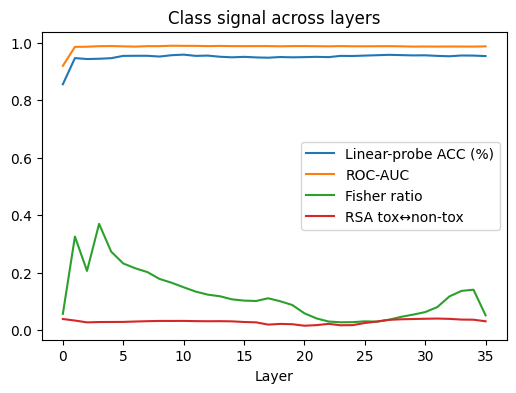

In [ ]:
from sklearn import preprocessing
acts_combined = acts_combined.cpu()

acc, auc   = layerwise_linear_probe(acts_combined, labels) # scale dependant
fisher     = fisher_ratio(acts_combined, labels) # scale invariant
rsa_scores = layerwise_rsa(acts_combined, labels) # scale invariant

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(acc,  label="Linear-probe ACC (%)")
plt.plot(auc,      label="ROC-AUC")
plt.plot(fisher,   label="Fisher ratio")
plt.plot(rsa_scores, label="RSA tox↔︎non-tox")
plt.xlabel("Layer"); plt.legend(); plt.title("Class signal across layers")
plt.show()

# Direction Extraction

In [ ]:
@contextlib.contextmanager
def add_hooks(
    module_forward_pre_hooks: List[Tuple[torch.nn.Module, Callable]],
    module_forward_hooks: List[Tuple[torch.nn.Module, Callable]],
    **kwargs
):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_forward_pre_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward pre hook on the module
    module_forward_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for module, hook in module_forward_pre_hooks:
            partial_hook = functools.partial(hook, **kwargs)
            handles.append(module.register_forward_pre_hook(partial_hook))
        for module, hook in module_forward_hooks:
            partial_hook = functools.partial(hook, **kwargs)
            handles.append(module.register_forward_hook(partial_hook))
        yield
    finally:
        for h in handles:
            h.remove()


def get_activations(model, tokenizer, instructions, block_modules: List[torch.nn.Module], store_means=True, batch_size=8, positions=[-1]):

    def mean_hook(layer, cache, n_samples, positions):
        def _hook(module, inputs):
            act = inputs[0][:, positions, :]          # [B, P, d]
            cache[:, layer] += act.sum(0) / n_samples # mean update
        return _hook


    def sample_hook(layer, cache, positions, batch_start):
        def _hook(module, inputs):
            act = inputs[0][:, positions, :]              # [B, P, d]
            B = act.size(0)
            cache[batch_start:batch_start+B, :, layer, :] = act
        return _hook

    torch.cuda.empty_cache()

    n_positions = len(positions)
    n_layers = model.config.num_hidden_layers
    n_samples = len(instructions)
    d_model = model.config.hidden_size
    device= model.device

    if store_means:
        # we store the mean activations in high-precision to avoid numerical issues
        activations = torch.zeros((n_positions, n_layers, d_model), dtype=torch.float64, device=device)
    else:
        # to avoid mem issues we fallback to .32 precision
        activations = torch.zeros((n_samples, n_positions, n_layers, d_model), dtype=torch.float32, device=device)

    for batch_start in tqdm(range(0, n_samples, batch_size), total = int(n_samples/batch_size), desc= 'Gathering activations'):
        inputs = tokenizer(
            instructions[batch_start:batch_start+batch_size],
            return_tensors="pt",
            padding=True
            )

        if store_means:
            fwd_pre_hooks = [
                (block_modules[l], mean_hook(l, activations, n_samples, positions))
                for l in range(n_layers)
            ]
        else:
            fwd_pre_hooks = [
                (block_modules[l], sample_hook(l, activations, positions, batch_start))
                for l in range(n_layers)
            ]
        with torch.inference_mode():
          with add_hooks(fwd_pre_hooks, []):
              model(
                  input_ids=inputs.input_ids.to(model.device),
                  attention_mask=inputs.attention_mask.to(model.device),
              )


    # of size (n_positions, n_layers, d_model) if store_means = False
    # of size (n_samples, n_positions, n_layers, d_model) if store_means = True
    return activations

def get_mean_diff(model, tokenizer, tox_seqs, non_tox_seqs, block_modules: List[torch.nn.Module], batch_size=32, positions=[-1]):
    activations_tox = get_activations(model, tokenizer, tox_seqs, block_modules, batch_size=batch_size, positions=positions, store_means=True)
    activations_non_tox = get_activations(model, tokenizer, non_tox_seqs, block_modules, batch_size=batch_size, positions=positions, store_means=True)

    mean_diff: Float[Tensor, "n_positions n_layers d_model"] = activations_tox - activations_non_tox

    return mean_diff

import os

def generate_directions(model, tokenizer, block_modules, tox_seqs, non_tox_seqs, artifact_dir):
    if not os.path.exists(artifact_dir):
        os.makedirs(artifact_dir)

    mean_diffs = get_mean_diff(model, tokenizer, tox_seqs, non_tox_seqs, block_modules)

    assert not mean_diffs.isnan().any()

    torch.save(mean_diffs, f"{artifact_dir}/mean_diffs.pt")

    return mean_diffs

In [ ]:
protgpt2_tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [ ]:
mean_diffs = generate_directions(
    protgpt2_model,
    protgpt2_tokenizer,
    block_modules,
    tox_seqs,
    non_tox_seqs,
    'mean_diffs_protgpt2_random1000_toxdl2'
)

Gathering activations: 32it [00:41,  1.29s/it]
Gathering activations: 32it [00:49,  1.53s/it]


In [ ]:
mean_diffs.shape

torch.Size([1, 36, 1280])